In [225]:
import warnings

warnings.filterwarnings(action='ignore', category=FutureWarning, module='sklearn')

In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV

df_hitters = pd.read_csv('./Data/Hitters.csv')
df_hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [227]:
na_cols = df_hitters.isna().any(axis=0)
na_cols = na_cols[na_cols == True]
na_cols

Salary    True
dtype: bool

In [278]:
df_hitters.dropna(inplace=True)
df_hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


## Part I: Different Model Specs

In [229]:
X = df_hitters.drop(columns=['Salary'])
y = df_hitters['Salary']

X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.8, random_state=42)

### A. Regression without regularization

In [230]:
ct = ColumnTransformer(
    [("scalar", StandardScaler(), make_column_selector(dtype_include=np.number)),
     ("ohe", OneHotEncoder(handle_unknown='ignore', sparse_output = False), make_column_selector(dtype_include=object))],
    remainder="passthrough"
)

pipeline_lr = Pipeline(
    [("preprocessing", ct),
     ("lr", LinearRegression())]
)

In [231]:
pipeline_lr.fit(X_train, y_train)

def interpret_coef(pipeline, pipe_type):
    # Mapping of coefficients to their names mostly came from ChatGPT
    preprocessor = pipeline.named_steps['preprocessing']
    model = pipeline.named_steps[pipe_type]

    cat_features = preprocessor.named_transformers_['ohe'].get_feature_names_out()

    num_features = preprocessor.transformers_[0][2]
    num_features = X_train[num_features].columns

    all_feature_names = np.concatenate([num_features, cat_features], axis=0)

    coefficients = model.coef_

    feature_coef_mapping = dict(zip(all_feature_names, coefficients))
    sorted_feature_coef = sorted(feature_coef_mapping.items(), key=lambda x: abs(x[1]), reverse=True)

    for feature, coef in sorted_feature_coef:
        print(f"{feature}: {coef}")

interpret_coef(pipeline_lr, "lr")

CHits: 1510.0509717786363
CAtBat: -1064.3919117056735
AtBat: -601.7954408126036
CRBI: -496.0058501769132
CHmRun: 444.36638253326964
Hits: 421.8585831619629
Assists: 207.6118034703465
Years: -197.98540305814885
Walks: 171.66449140462063
PutOuts: 118.9077894439439
Errors: -113.75089830810694
Runs: -94.4930519354098
Division_W: -84.51261638630164
Division_E: 84.51261638629963
HmRun: 78.334663453774
CWalks: -65.05863196842725
NewLeague_A: -41.7979693767622
NewLeague_N: 41.797969376761316
CRuns: 40.57502998475301
League_N: -22.112679904994295
League_A: 22.11267990499075
RBI: -10.758492102215186


Highest absolue values of coefficients are weighted heavier. CHits (positive), CAtBat (negative), AtBat (negative), CRBI (negative), and ChmRun (positive) are the heaviest weighted features.

In [232]:
def get_mse(pipeline, X_test, X, y, pipe_type):
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE for {pipe_type} Regression Test Set: {mse}")

    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"MSE for {pipe_type} Regression Cross Validation: {-scores.mean()}")

get_mse(pipeline_lr, X_test, X, y, "Linear")

MSE for Linear Regression Test Set: 186534.11801144594
MSE for Linear Regression Cross Validation: 121136.31031816883


### B. Ridge regression

In [233]:
pipeline_ridge = Pipeline(
    [("preprocessing", ct),
     ("ridge", Ridge())]
)

In [234]:
alpha_values = [0.001, 0.01, 0.1, 1, 10]

alphas = {'ridge__alpha': alpha_values}

gscv = GridSearchCV(pipeline_ridge, alphas, cv=5, scoring='r2')
gscv.fit(X, y)

best_alpha = gscv.best_params_['ridge__alpha']
best_score = gscv.best_score_

print(f"Best alpha: {best_alpha}")

Best alpha: 10


In [235]:
pipeline_ridge.set_params(ridge__alpha=10)
pipeline_ridge.fit(X_train, y_train)

interpret_coef(pipeline_ridge, "ridge")

Walks: 90.77190141136514
AtBat: -86.56863675193406
Years: -86.54737161219488
CHmRun: 72.5664130920856
CRuns: 67.41574375162358
Division_W: -66.85599604174647
Division_E: 66.85599604174645
CHits: 56.60201298188079
CRBI: 50.15026900544187
Errors: -43.73284046281286
Assists: 43.134687712637586
Runs: 39.30596377990093
HmRun: -31.999454890388797
Hits: 27.044245811164334
RBI: 25.716364012555044
CWalks: -22.502783829480475
PutOuts: 20.373948532572246
League_A: -8.686768096628148
League_N: 8.686768096628104
NewLeague_A: -4.316843090866565
NewLeague_N: 4.316843090866565
CAtBat: 1.7103936927112005


Walks (positive), AtBat (negative), Years (Negative), CmHmRun (Positive), and CRuns (positive) are the heaviest weighted features.

In [236]:
get_mse(pipeline_ridge, X_test, X, y, "Ridge")

MSE for Ridge Regression Test Set: 109727.70343910668
MSE for Ridge Regression Cross Validation: 119348.98477570352


### C. Lasso Regression

In [237]:
pipeline_lasso = Pipeline(
    [("preprocessing", ct),
     ("lasso", Lasso(max_iter=10000))]
)

In [238]:
alphas = {'lasso__alpha': alpha_values}

gscv = GridSearchCV(pipeline_lasso, alphas, cv=5, scoring='r2')
gscv.fit(X, y)

best_alpha = gscv.best_params_['lasso__alpha']
best_score = gscv.best_score_

print(f"Best alpha: {best_alpha}")

Best alpha: 10


In [239]:
pipeline_lasso.set_params(lasso__alpha=10)
pipeline_lasso.fit(X_train, y_train)

interpret_coef(pipeline_lasso, "lasso")

Years: -153.69279237333373
Division_E: 152.4884197014306
AtBat: -149.6973272003224
CHits: 129.31306743277264
Walks: 120.72793268684454
CHmRun: 109.33189287077279
Hits: 80.23705258831548
CRuns: 70.39842426267685
Assists: 34.49867295644839
Errors: -26.437537268081
PutOuts: 25.110410675659942
CWalks: -19.634060313107366
Division_W: -2.574958290275919e-14
HmRun: -0.0
Runs: 0.0
RBI: 0.0
CAtBat: 0.0
CRBI: 0.0
League_A: -0.0
League_N: 0.0
NewLeague_A: -0.0
NewLeague_N: 0.0


Years (negative), Division_E (positive), AtBat (negative), CHits (positive), and Walks (positive) are the heaviest weighted features.

In [240]:
get_mse(pipeline_lasso, X_test, X, y, "Lasso")

MSE for Lasso Regression Test Set: 112278.39863176274
MSE for Lasso Regression Cross Validation: 121828.10222019239


### D. Elastic Net

In [241]:
pipeline_elastic = Pipeline(
    [("preprocessing", ct),
     ("elastic", ElasticNet(max_iter=10000))]
)

In [242]:
params = {
    "elastic__alpha": [0.001, 0.01, 0.1, 1, 10],
    "elastic__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]
}

gscv = GridSearchCV(pipeline_elastic, params, cv=5, scoring='r2')
gscv.fit(X, y)

best_alpha = gscv.best_params_['elastic__alpha']
best_l1_ratio = gscv.best_params_['elastic__l1_ratio']
best_score = gscv.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.229e+06, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are mor

Best alpha: 1
Best l1_ratio: 0.25


In [243]:
pipeline_elastic.set_params(elastic__alpha=1, elastic__l1_ratio=0.25)
pipeline_elastic.fit(X_train, y_train)

interpret_coef(pipeline_elastic, "elastic")

Walks: 53.81979475232899
CHmRun: 37.67077582658229
CRuns: 36.97524408378039
Division_E: 32.1726629461927
Division_W: -32.17262303144818
CRBI: 30.677299944165174
CHits: 30.378030480912717
Runs: 22.728436469445757
Years: -20.27354034294782
AtBat: -18.50761998223963
RBI: 16.167326143370992
Errors: -14.609219896163093
HmRun: -14.43174407853622
Assists: 14.37930774082932
Hits: 14.19495559874636
CAtBat: 13.563109013815389
CWalks: 10.842730919613258
League_N: 4.249075538101903
League_A: -4.249057436345892
PutOuts: 3.6576681406235116
NewLeague_A: -3.352665969754639
NewLeague_N: 3.352662289175089


Walks (positive), CHmRun (positive), CRuns (positive), Division_E (Positive), and Division_W (Negative) are the heaviest weighted features.

In [244]:
get_mse(pipeline_elastic, X_test, X, y, "Elastic Net")

MSE for Elastic Net Regression Test Set: 120705.48015634934
MSE for Elastic Net Regression Cross Validation: 121374.33335443737


## Part II. Variable Selection

Most important numerical features: Walks\
5 most important numerical features: Walks, CHmRun, AtBat, CHits, Years\
Most important categorical feature: Division

### Most important numerical feature

In [245]:
X_num = X[['Walks']]
X_test, X_train, y_test, y_train = train_test_split(X_num, y, train_size=0.8, random_state=42)

In [246]:
pipeline_lr.fit(X_train, y_train)
get_mse(pipeline_lr, X_test, X_num, y, "Linear")

MSE for Linear Regression Test Set: 168708.64204952674
MSE for Linear Regression Cross Validation: 167500.94936210068


In [247]:
alphas = {'ridge__alpha': alpha_values}

gscv = GridSearchCV(pipeline_ridge, alphas, cv=5, scoring='r2')
gscv.fit(X_num, y)

best_alpha = gscv.best_params_['ridge__alpha']
best_score = gscv.best_score_

print(f"Best alpha: {best_alpha}")

Best alpha: 10


In [248]:
pipeline_ridge.fit(X_train, y_train)

pipeline_ridge.set_params(ridge__alpha=10)
get_mse(pipeline_ridge, X_test, X_num, y, "Ridge")

MSE for Ridge Regression Test Set: 172382.3545058576
MSE for Ridge Regression Cross Validation: 167470.03286028458


In [249]:
alphas = {'lasso__alpha': alpha_values}

gscv = GridSearchCV(pipeline_lasso, alphas, cv=5, scoring='r2')
gscv.fit(X_num, y)

best_alpha = gscv.best_params_['lasso__alpha']
best_score = gscv.best_score_

print(f"Best alpha: {best_alpha}")

Best alpha: 10


In [250]:
pipeline_lasso.fit(X_train, y_train)

pipeline_lasso.set_params(lasso__alpha=10)
get_mse(pipeline_lasso, X_test, X_num, y, "Lasso")

MSE for Lasso Regression Test Set: 170004.3916805507
MSE for Lasso Regression Cross Validation: 167637.41567828745


In [251]:
params = {
    "elastic__alpha": [0.001, 0.01, 0.1, 1, 10],
    "elastic__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]
}

gscv = GridSearchCV(pipeline_elastic, params, cv=5, scoring='r2')
gscv.fit(X_num, y)

best_alpha = gscv.best_params_['elastic__alpha']
best_l1_ratio = gscv.best_params_['elastic__l1_ratio']
best_score = gscv.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are mor

Best alpha: 0.1
Best l1_ratio: 0.0


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.188e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [252]:
pipeline_elastic.fit(X_train, y_train)

pipeline_elastic.set_params(elastic__alpha=0.1, elastic__l1_ratio=0)
get_mse(pipeline_elastic, X_test, X_num, y, "Elastic Net")

MSE for Elastic Net Regression Test Set: 181076.92850068744
MSE for Elastic Net Regression Cross Validation: 167601.84767511935


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are mor

### 5 most important numerical features

In [253]:
X_num_five = X[['Walks', 'CHmRun', 'AtBat', 'CHits', 'Years']]
X_test, X_train, y_test, y_train = train_test_split(X_num_five, y, train_size=0.8, random_state=42)

In [254]:
pipeline_lr.fit(X_train, y_train)
get_mse(pipeline_lr, X_test, X_num_five, y, "Linear")

MSE for Linear Regression Test Set: 128932.13049924304
MSE for Linear Regression Cross Validation: 127101.67337838309


In [255]:
alphas = {'ridge__alpha': alpha_values}

gscv = GridSearchCV(pipeline_ridge, alphas, cv=5, scoring='r2')
gscv.fit(X_num_five, y)

best_alpha = gscv.best_params_['ridge__alpha']
best_score = gscv.best_score_

print(f"Best alpha: {best_alpha}")

Best alpha: 10


In [256]:
pipeline_ridge.fit(X_train, y_train)

pipeline_ridge.set_params(ridge__alpha=10)
get_mse(pipeline_ridge, X_test, X_num_five, y, "Ridge")

MSE for Ridge Regression Test Set: 127025.03406822705
MSE for Ridge Regression Cross Validation: 126738.55431470159


In [257]:
alphas = {'lasso__alpha': alpha_values}

gscv = GridSearchCV(pipeline_lasso, alphas, cv=5, scoring='r2')
gscv.fit(X_num_five, y)

best_alpha = gscv.best_params_['lasso__alpha']
best_score = gscv.best_score_

print(f"Best alpha: {best_alpha}")

Best alpha: 10


In [258]:
pipeline_lasso.fit(X_train, y_train)

pipeline_lasso.set_params(lasso__alpha=10)
get_mse(pipeline_lasso, X_test, X_num_five, y, "Lasso")

MSE for Lasso Regression Test Set: 123759.0295197112
MSE for Lasso Regression Cross Validation: 128550.30547944646


In [259]:
params = {
    "elastic__alpha": [0.001, 0.01, 0.1, 1, 10],
    "elastic__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]
}

gscv = GridSearchCV(pipeline_elastic, params, cv=5, scoring='r2')
gscv.fit(X_num_five, y)

best_alpha = gscv.best_params_['elastic__alpha']
best_l1_ratio = gscv.best_params_['elastic__l1_ratio']
best_score = gscv.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.374e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are mor

Best alpha: 1
Best l1_ratio: 0.75


In [260]:
pipeline_elastic.fit(X_train, y_train)

pipeline_elastic.set_params(elastic__alpha=1, elastic__l1_ratio=0.75)
get_mse(pipeline_elastic, X_test, X_num_five, y, "Elastic Net")

MSE for Elastic Net Regression Test Set: 126363.76587764468
MSE for Elastic Net Regression Cross Validation: 127438.37919591626


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.535e+06, tolerance: 9.586e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


### 5 most important numerical feature and interactions with best categorical feature

In [262]:
X_inter = X[['Walks', 'CHmRun', 'AtBat', 'CHits', 'Years', 'Division']]
X_test, X_train, y_test, y_train = train_test_split(X_inter, y, train_size=0.8, random_state=42)

In [264]:
pipeline_lr_inter = Pipeline(
    [("preprocessing", ct),
     ("interaction", PolynomialFeatures(interaction_only=True, include_bias=False)),
     ("lr", LinearRegression())]
)

pipeline_lr_inter.fit(X_train, y_train)
get_mse(pipeline_lr_inter, X_test, X_inter, y, "Linear")

MSE for Linear Regression Test Set: 141383.40424933686
MSE for Linear Regression Cross Validation: 87226.67047481184


In [265]:
pipeline_ridge_inter = Pipeline(
    [("preprocessing", ct),
     ("interaction", PolynomialFeatures(interaction_only=True, include_bias=False)),
     ("ridge", Ridge())]
)

alphas = {'ridge__alpha': alpha_values}

gscv = GridSearchCV(pipeline_ridge_inter, alphas, cv=5, scoring='r2')
gscv.fit(X_inter, y)

best_alpha = gscv.best_params_['ridge__alpha']
best_score = gscv.best_score_

print(f"Best alpha: {best_alpha}")

Best alpha: 10


In [270]:
pipeline_ridge_inter.fit(X_train, y_train)

pipeline_ridge_inter.set_params(ridge__alpha=10)
get_mse(pipeline_ridge_inter, X_test, X_inter, y, "Ridge")

MSE for Ridge Regression Test Set: 102969.8760456754
MSE for Ridge Regression Cross Validation: 87082.6321708193


In [271]:
pipeline_lasso_inter = Pipeline(
    [("preprocessing", ct),
     ("interaction", PolynomialFeatures(interaction_only=True, include_bias=False)),
     ("lasso", Lasso())]
)

alphas = {'lasso__alpha': alpha_values}

gscv = GridSearchCV(pipeline_lasso_inter, alphas, cv=5, scoring='r2')
gscv.fit(X_inter, y)

best_alpha = gscv.best_params_['lasso__alpha']
best_score = gscv.best_score_

print(f"Best alpha: {best_alpha}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.870e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

Best alpha: 1


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e+06, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e+06, tolerance: 4.558e+03
  model = cd_fast.enet_coordinate_descent(


In [272]:
pipeline_lasso_inter.fit(X_train, y_train)

pipeline_lasso_inter.set_params(lasso__alpha=1)
get_mse(pipeline_lasso_inter, X_test, X_inter, y, "Lasso")

MSE for Lasso Regression Test Set: 119335.73831202232
MSE for Lasso Regression Cross Validation: 85931.02810146297


In [273]:
pipeline_elastic_inter = Pipeline(
    [("preprocessing", ct),
     ("interaction", PolynomialFeatures(interaction_only=True, include_bias=False)),
     ("elastic", ElasticNet())]
)

params = {
    "elastic__alpha": [0.001, 0.01, 0.1, 1, 10],
    "elastic__l1_ratio": [0.0, 0.25, 0.5, 0.75, 1.0]
}

gscv = GridSearchCV(pipeline_elastic_inter, params, cv=5, scoring='r2')
gscv.fit(X_inter, y)

best_alpha = gscv.best_params_['elastic__alpha']
best_l1_ratio = gscv.best_params_['elastic__l1_ratio']
best_score = gscv.best_score_

print(f"Best alpha: {best_alpha}")
print(f"Best l1_ratio: {best_l1_ratio}")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.569e+06, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.199e+06, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are mor

Best alpha: 0.1
Best l1_ratio: 0.75


In [274]:
pipeline_elastic_inter.fit(X_train, y_train)

pipeline_elastic_inter.set_params(elastic__alpha=0.1, elastic__l1_ratio=0.75)
get_mse(pipeline_elastic_inter, X_test, X_inter, y, "Elastic Net")

MSE for Elastic Net Regression Test Set: 111312.30138553644
MSE for Elastic Net Regression Cross Validation: 86207.70020510977


## Part III. Discussion

### A. Ridge

Coefficients were much smaller which makes sense since Ridge regression penalizes large coeffiecients

### B. LASSO

Some were the same in Part II, but the interaction model was different. This makes sense since different sets of features may or may not have different optimal λ's. The MSE's were also different which makes sense since each model used a different set of features, and some were better at predictions than others.

### C. Elastic Net

Elastic net uses a "best of both worlds" approach.

## Part IV: Final Model

In [276]:
X_test, X_train, y_test, y_train = train_test_split(X, y, train_size=0.8, random_state=42)

pipeline_lasso_inter.fit(X_train, y_train)
pipeline_lasso_inter.set_params(lasso__alpha=1)

get_mse(pipeline_lasso_inter, X_test, X, y, "Lasso")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.532e+03, tolerance: 9.586e+02
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.433e+05, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

MSE for Lasso Regression Test Set: 419230.9775579271
MSE for Lasso Regression Cross Validation: 104208.8460047965


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.067e+05, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.527e+05, tolerance: 4.558e+03
  model = cd_fast.enet_coordinate_descent(


Final model was the lasso pipeline on the 5 most important numerical features and their interactions with the best categorical feature. The Lasso model was tuned with an alpha parameter of 1. The model's performance was evaluated using MSE, which was approximately 419,231 on the test set. The MSE for cross-validation was significantly lower at about 104,209.

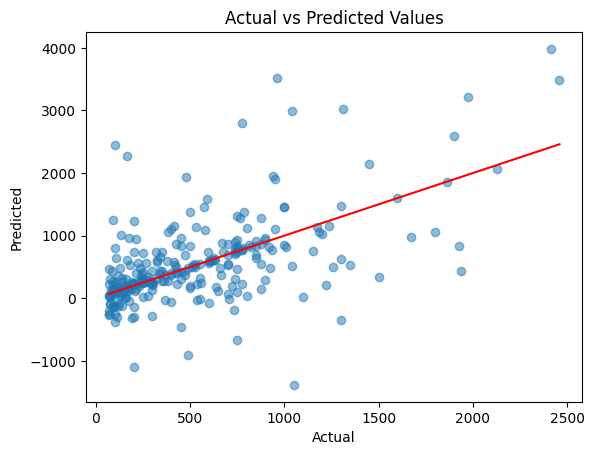

In [285]:
y_pred = pipeline_lasso_inter.predict(X)

plt.scatter(y, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')

plt.plot([min(y), max(y)], [min(y), max(y)], color='red')

plt.show()